In [1]:
#import data
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import array as arr
import statistics
# DataFrames
param_list = pd.read_csv("_equidim_dfn_pressure_v2_2.csv")
print(param_list.keys())
param_list = param_list.sort_values(by="Pressure") # sort data pressure in ascending order

param_list = param_list.reset_index(drop=True) # reindex data file aac. to sorted pressure in ascending order

# delete fracture nodes
# param_list = param_list.drop(labels=range(86936, int(param_list.size/3)), axis=0)
#print to csv file
param_list.to_csv("param_list.csv")

#print(param_list)

param_list['X'] = param_list['X'].astype(np.float64)
param_list['Y'] = param_list['Y'].astype(np.float64)
param_list['Pressure'] = param_list['Pressure'].astype(np.float64)

pmin=min(param_list.iloc[:,2]) # minimum pressure level
pmax=max(param_list.iloc[:,2]) # maximum pressure level

param_list['Pressure'] = param_list['Pressure'] - pmin
#print to csv file
param_list.to_csv("param_list_wrt_pmin.csv")
X = param_list.iloc[:,0]
Y = param_list.iloc[:,1]
Z = param_list.iloc[:,2]


print(pmin, pmax)



Index(['X', 'Y', 'Pressure'], dtype='object')
1002212.1678326272 4507204.992863161


In [2]:
#optimize pressure clusters
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# number of clusters
n_blocks=11 #number_of_blocks
n_m_blocks= n_blocks-1 #number_of_matrix_blocks

#add index as coloumn
data_to_cluster = Z.rename_axis('index').reset_index()

data_to_cluster.iloc[:,0]=1

# scaler_data_to_cluster_std = StandardScaler().fit(data_to_cluster)

# data_to_cluster_std = scaler_data_to_cluster_std.transform(data_to_cluster)

# data_to_cluster_back_transformed=scaler_data_to_cluster_std.inverse_transform(data_to_cluster_std)


#clustering with kmeans
km = KMeans(n_clusters=n_m_blocks, n_init=50,max_iter=1000, tol=1E-8)
km.fit(data_to_cluster)

#print to csv file
data_to_cluster.to_csv("data_to_cluster.csv")

[[1.00000000e+00 3.48391101e+06]
 [1.00000000e+00 1.84531210e+06]
 [1.00000000e+00 2.83482115e+06]
 [1.00000000e+00 1.43441249e+06]
 [1.00000000e+00 3.09444695e+06]
 [1.00000000e+00 9.40044320e+05]
 [1.00000000e+00 2.53624646e+06]
 [1.00000000e+00 2.19934550e+06]
 [1.00000000e+00 3.05652916e+05]
 [1.00000000e+00 3.31614193e+06]]
0        1
1        1
2        1
3        1
4        1
        ..
93352    1
93353    1
93354    1
93355    1
93356    1
Name: index, Length: 93357, dtype: int64 0        0.000000e+00
1        1.469965e+03
2        1.518838e+03
3        1.703494e+03
4        2.040289e+03
             ...     
93352    3.504993e+06
93353    3.504993e+06
93354    3.504993e+06
93355    3.504993e+06
93356    3.504993e+06
Name: Pressure, Length: 93357, dtype: float64


Text(0.5, 1.0, 'real pressure clustered data')

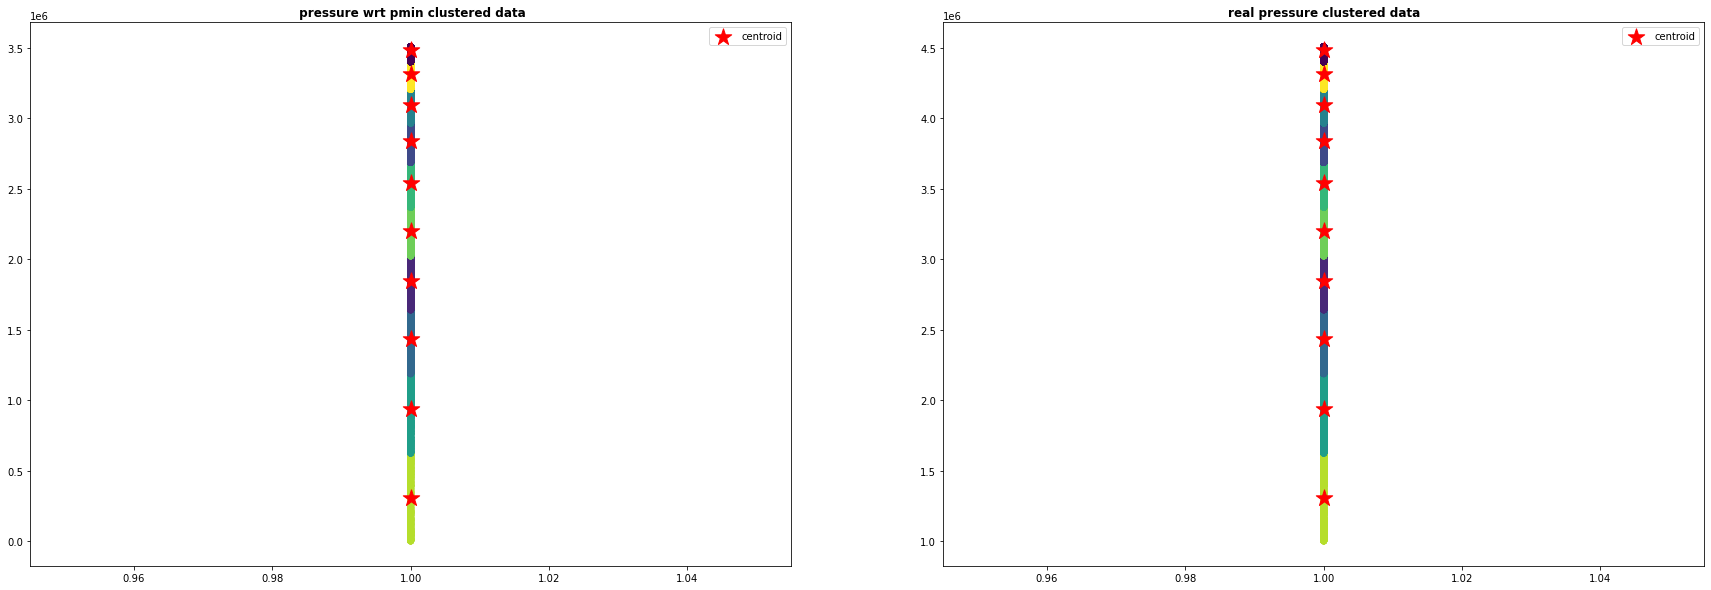

In [3]:
#plot results
centroids = km.cluster_centers_
print(centroids)
print(data_to_cluster.iloc[:, 0], data_to_cluster.iloc[:, 1])
# Plot the clustered data
fig, ax = plt.subplots(1,2,figsize=(30, 10))

ax = np.ravel(ax)

centers = []

ax[0].scatter(data_to_cluster.iloc[:, 0], data_to_cluster.iloc[:, 1], c=km.labels_)
ax[0].scatter(centroids[:, 0], centroids[:, 1], marker="*", s=300, c="r", label='centroid')
ax[0].legend()
#ax[0].set_xlim([-2, 2])
#ax[0].set_ylim([-2, 2])
#ax[0].xlabel('İndex')
#ax[0].ylabel('Pressure')
ax[0].set_title(' pressure wrt pmin clustered data', fontweight='bold')
#ax[0].set_aspect('equal')

ax[1].scatter(data_to_cluster.iloc[:, 0], pmin+data_to_cluster.iloc[:, 1], c=km.labels_)
ax[1].scatter(centroids[:, 0], pmin+centroids[:, 1], marker="*", s=300, c="r", label='centroid')
ax[1].legend()
# plt.set_xlim([0,2])
#ax[1].set_ylim([pmin-2, pmax+2])
#ax[1].xlabel('İndex')
#ax[1].ylabel('Pressure')
ax[1].set_title('real pressure clustered data', fontweight='bold')
#ax[1].set_aspect('equal')
#plt.tight_layout()

In [4]:
#add cluster indices to param_list as a coloumn
import bisect

param_list_cluster_unsorted=param_list

cluster=km.labels_.tolist()

param_list_cluster_unsorted['cluster']=cluster

#print to csv file
param_list_cluster_unsorted.to_csv("param_list_unsorted_clusters.csv")

#print(param_list_cluster_unsorted)

#create centroids data frame
centroids_df=pd.DataFrame(centroids)
centroids_df=centroids_df.rename(columns={0: "index_interp", 1: "pressure"})
print(centroids_df)

#screen lvls_index
lvls_index = arr.array('i', [ 1 for i in range(0,n_m_blocks+1) ]) # initialize indices in data file related with contour levels to 1
lvls_index[0]=0 # first index of contour in data data file
lvls_index[n_m_blocks]=int(param_list_cluster_unsorted.size/4-1) # last index of contour in data data file

cluster_current= arr.array('i', [ 1 for i in range(0,n_m_blocks+1) ])
cluster_current[0]= 3#param_list_cluster_unsorted.iloc[0,3]

cluster_current= arr.array('i', [ 1 for i in range(0,n_m_blocks+1) ])
cluster_current[0]=param_list_cluster_unsorted.iloc[0,3]
cluster_index=0
param_list_cluster_sorted=param_list_cluster_unsorted.copy()
for i in range (0, int(param_list_cluster_unsorted.size/4-1)):
    param_list_cluster_sorted.iloc[i,3]=cluster_index
    if(param_list_cluster_unsorted.iloc[i,3] != param_list_cluster_unsorted.iloc[i+1,3]):
        cluster_index=cluster_index+1
        lvls_index[cluster_index]=i
        a=2
param_list_cluster_sorted.iloc[int(param_list_cluster_unsorted.size/4-1),3]=cluster_index   

#print to csv file
param_list_cluster_sorted.to_csv("param_list_sorted_clusters.csv")

lvls = arr.array("d",[ pmin for i in range(0,n_m_blocks+1) ]) # initialize all contour levels to pmin

print("lvls_index",lvls_index)


lvls[0]=pmin

for i in range (0, n_m_blocks+1):
       lvls[i]=pmin+param_list_cluster_sorted.iloc[lvls_index[i],2]
        
print("levels",lvls)

# x0 for random forest input
x0=lvls_index[1:n_m_blocks]

x0 = [x/ lvls_index[n_m_blocks]  for x in x0]

print("x0",x0)

x0_back_tranform=[x* lvls_index[n_m_blocks]  for x in x0]
print("x0_back",x0_back_tranform)

   index_interp      pressure
0           1.0  3.483911e+06
1           1.0  1.845312e+06
2           1.0  2.834821e+06
3           1.0  1.434412e+06
4           1.0  3.094447e+06
5           1.0  9.400443e+05
6           1.0  2.536246e+06
7           1.0  2.199346e+06
8           1.0  3.056529e+05
9           1.0  3.316142e+06
lvls_index array('i', [0, 766, 1942, 3589, 5640, 8377, 12597, 19245, 29691, 45964, 93356])
levels array('d', [1002212.1678326272, 1624136.9892984906, 2188694.204476968, 2641778.7272595284, 3024343.775829038, 3369952.166671115, 3687681.8558509294, 3966796.530776401, 4207474.699080926, 4402235.259954859, 4507204.992863161])
x0 [0.00820515017781396, 0.020802090920776384, 0.03844423497150692, 0.06041389948155448, 0.08973177942499679, 0.13493508719311023, 0.2061463644543468, 0.3180406187068855, 0.4923518574060585]
x0_back [766.0, 1942.0000000000002, 3589.0, 5640.0, 8377.0, 12596.999999999998, 19245.0, 29691.000000000004, 45964.0]
